# Calculating Streaks in NBA Playoffs Shot Data

First, we will look at a simple example to better understand how to calculate streaks. Then we'll apply this technique to the real dataset, and after that we'll create some charts, as they make much easier to inspect discovered trends and analyze them.

# Calculating Streaks (Simple Example)

In [1]:
%load_ext nb_black
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt

# import seaborn as sns

# sns.set()

<IPython.core.display.Javascript object>

## Creating Test Streak Data

As we mentioned earlier, we'll generate small test data with the results of the throw - `miss`, `make`. This data similar to the column of the dataset that we will use later. For this purpose we will use `numpy.random.choice` from a NumPy package. We'll get the sequence of success and fail results with associated probabilities 0.7 and 0.3 respectively.

In [2]:
# set random state for reproducibility
np.random.seed(42)
streaks = np.random.choice(["make", "miss"], size=10, p=[0.7, 0.3])
# convert Series to DataFrame
streaks = pd.Series(streaks, name="result").to_frame()
streaks

,result
0,make
1,miss
2,miss
3,make
4,make
5,make
6,make
7,miss
8,make
9,miss


<IPython.core.display.Javascript object>

By inspecting the above output, we obtained the following streaks with a length from one to four:
1. `[make]`
2. `[miss, miss]`
3. `[make, make, make, make]`
4. `[miss]`
5. `[make]`
6. `[miss]`

## Identifying the Start of Each Streak

The next step is to define where each streak starts. To accomplish this we'll create a new column `start_of_streak`. More concretely we will do the following:
 - create a new column `start_of_streak` equivalent to the column `result`, but shifted one position forward
 - compare for each row `result` and `start_of_streak`. If they are not equal, hence, this indicates the beginning of a new streak

In [3]:
streaks["start_of_streak"] = streaks["result"].ne(streaks["result"].shift())

<IPython.core.display.Javascript object>

In [4]:
streaks

,result,start_of_streak
0,make,True
1,miss,True
2,miss,False
3,make,True
4,make,False
5,make,False
6,make,False
7,miss,True
8,make,True
9,miss,True


<IPython.core.display.Javascript object>

## Creating Streak IDs

Let's move on to another step - creating an identifier `streak_id` for each streak. As Pandas treats boolean values as `0` and `1`, so we can use a cumulative sum of `start_of_streak` column.

In [5]:
streaks["streak_id"] = streaks["start_of_streak"].cumsum()
streaks

,result,start_of_streak,streak_id
0,make,True,1
1,miss,True,2
2,miss,False,2
3,make,True,3
4,make,False,3
5,make,False,3
6,make,False,3
7,miss,True,4
8,make,True,5
9,miss,True,6


<IPython.core.display.Javascript object>

## Counting Streaks

For our further analysis it will be interesting to know the lengths of streaks. One way to do this would be using a cumulative count of `streak_id` column. We also need to add one, because Pandas numbers each item in each group from zero.

In [6]:
streaks["streak_counter"] = streaks.groupby("streak_id").cumcount() + 1
streaks

,result,start_of_streak,streak_id,streak_counter
0,make,True,1,1
1,miss,True,2,1
2,miss,False,2,2
3,make,True,3,1
4,make,False,3,2
5,make,False,3,3
6,make,False,3,4
7,miss,True,4,1
8,make,True,5,1
9,miss,True,6,1


<IPython.core.display.Javascript object>

# Calculating Streaks (NBA Playoffs Shot Data)

We'll be working with NBA dataset, containing shot data from the 2018 NBA playoffs. This data was obtained using the NBA stats API. First, let's read in the data and take a peek at the first few rows.

In [7]:
shots = pd.read_csv("data/playoff_shots.csv")
shots.head()

,game_id,game_code,game_description,period,period_time,player_name,player_id,team,shot_type,result
0,41700151,20180414/SASGSW,"GSW v SAS, G1",1,11:43,Draymond Green,203110,Golden State Warriors,2PT,miss
1,41700151,20180414/SASGSW,"GSW v SAS, G1",1,11:16,Patty Mills,201988,San Antonio Spurs,2PT,miss
2,41700151,20180414/SASGSW,"GSW v SAS, G1",1,11:08,Kevin Durant,201142,Golden State Warriors,3PT,miss
3,41700151,20180414/SASGSW,"GSW v SAS, G1",1,10:50,Kevin Durant,201142,Golden State Warriors,2PT,make
4,41700151,20180414/SASGSW,"GSW v SAS, G1",1,10:22,Danny Green,201980,San Antonio Spurs,3PT,miss


<IPython.core.display.Javascript object>

Let's familiarize ourselves with the columns:
 - `game_id` - the identifier of the game 
 - `game_code` - the game code, consisting of the date and the abbreviations of each team
 - `game_description` - the description of the game. It includes home team, visiting team and series game number
 - `period` - the period of the game, in which the shot attempt was made
 - `period_time` - the time in the period when the shot attempt was made
 - `player_name` - the name of the player who attempted the shot
 - `player_id` - the identifier of the player who attempted the shot
 - `team` - the team the player belongs to
 - `shot_type` - the shot type. It takes one of the values - `2PT`, `3PT`, `FT`
 - `result` - the result of the shot - `make` or `miss`

Each row in the dataset represents a shot attempt in a chronological order.

In the future we will use sorting by `period_time`, so that it works correctly we need to convert it to `datetime`.

In [8]:
shots["period_time"] = pd.to_datetime(shots["period_time"], format="%H:%M").dt.time

<IPython.core.display.Javascript object>

Let's create a function, which will filter shot data by the player and the shot type.

In [9]:
def filter_shots(player_name, shot_type):
    """Return shot data for a single player and a shot type.

    Args:
       player_name (str): A string containing a player name to be
        filtered.
       shot_type (str): The shot type. One of '3PT', '2PT', 'FT'.

    Returns:
       DataFrame: A filtered dataframe of shot data.

    Raises:
       ValueError: A filtered dataframe is empty.
    """

    player_shots = shots.loc[
        (shots["player_name"] == player_name) & (shots["shot_type"] == shot_type)
    ].copy()
    player_shots.reset_index(inplace=True, drop=True)

    if player_shots.empty:
        raise ValueError(f"Player '{player_name}' has no shots of type '{shot_type}'.")

    return player_shots

<IPython.core.display.Javascript object>

Let's apply our function on [one of the best NBA players in 2018 year](https://www.washingtonpost.com/graphics/2018/sports/nba-top-100-players-2018/) - LeBron James.

In [10]:
lebron_james_ft = filter_shots("LeBron James", "FT")
lebron_james_ft

,game_id,game_code,game_description,period,period_time,player_name,player_id,team,shot_type,result
0,41700131,20180415/INDCLE,"CLE v IND, G1",1,01:52:00,LeBron James,2544,Cleveland Cavaliers,FT,make
1,41700131,20180415/INDCLE,"CLE v IND, G1",1,01:52:00,LeBron James,2544,Cleveland Cavaliers,FT,make
2,41700131,20180415/INDCLE,"CLE v IND, G1",2,07:07:00,LeBron James,2544,Cleveland Cavaliers,FT,make
3,41700131,20180415/INDCLE,"CLE v IND, G1",2,03:02:00,LeBron James,2544,Cleveland Cavaliers,FT,miss
4,41700131,20180415/INDCLE,"CLE v IND, G1",2,03:02:00,LeBron James,2544,Cleveland Cavaliers,FT,miss
...,...,...,...,...,...,...,...,...,...,...
208,41700404,20180608/GSWCLE,"CLE v GSW, G4",3,09:51:00,LeBron James,2544,Cleveland Cavaliers,FT,make
209,41700404,20180608/GSWCLE,"CLE v GSW, G4",3,02:59:00,LeBron James,2544,Cleveland Cavaliers,FT,make
210,41700404,20180608/GSWCLE,"CLE v GSW, G4",3,02:59:00,LeBron James,2544,Cleveland Cavaliers,FT,make
211,41700404,20180608/GSWCLE,"CLE v GSW, G4",4,05:06:00,LeBron James,2544,Cleveland Cavaliers,FT,make


<IPython.core.display.Javascript object>

LeBron James took 213 freethrows across the playoffs.

## Calculating  LeBron James’s Freethrow Streaks

## Creating a Streak Function

Since we will generate information about streaks on other players too, it would be convenient to create a separate function for this purpose. Additionally, we'll also add a column `end_of_strike`. It's equal to `start_of_strike`, but shifted one position back.

In [11]:
def generate_streak_info(shots):
    """Generate information about steraks
    for all players or for a specific player
    or  for a specific player and a shot type.

    Args:
       shots (DataFrame): A dataframe containing data about shots.
        Must contain a `results` column with two unique values for
        made and missed shots and be pre-sorted by the time. If information
        is needed only for a particular player, `shots` should be homogeneous.

    Returns:
        DataFrame: The original dataframe with new columns
         `streak_counter` containing integers with counts for each streak,
         `start_of_streak`, `end_of_streak`.
    """
    data = shots.loc[:, ["result", "player_id", "shot_type"]].copy()

    data["start_of_streak"] = (
        data["result"].ne(data["result"].shift())
        | data["player_id"].ne(data["player_id"].shift())
        | data["shot_type"].ne(data["shot_type"].shift())
    )
    # fill the last value with true
    data["end_of_streak"] = data["start_of_streak"].shift(-1, fill_value=True)

    data["streak_id"] = data["start_of_streak"].cumsum()
    data["streak_counter"] = data.groupby("streak_id").cumcount() + 1
    shots_with_streaks = pd.concat(
        [data[["streak_counter", "start_of_streak", "end_of_streak"]], shots], axis=1
    )

    return shots_with_streaks

<IPython.core.display.Javascript object>

Let's calculate freethrow streaks for LeBron James.

In [12]:
lebron_james_ft_streaks = generate_streak_info(lebron_james_ft)

<IPython.core.display.Javascript object>

In [13]:
lebron_james_ft_streaks

,streak_counter,start_of_streak,end_of_streak,game_id,game_code,game_description,period,period_time,player_name,player_id,team,shot_type,result
0,1,True,False,41700131,20180415/INDCLE,"CLE v IND, G1",1,01:52:00,LeBron James,2544,Cleveland Cavaliers,FT,make
1,2,False,False,41700131,20180415/INDCLE,"CLE v IND, G1",1,01:52:00,LeBron James,2544,Cleveland Cavaliers,FT,make
2,3,False,True,41700131,20180415/INDCLE,"CLE v IND, G1",2,07:07:00,LeBron James,2544,Cleveland Cavaliers,FT,make
3,1,True,False,41700131,20180415/INDCLE,"CLE v IND, G1",2,03:02:00,LeBron James,2544,Cleveland Cavaliers,FT,miss
4,2,False,False,41700131,20180415/INDCLE,"CLE v IND, G1",2,03:02:00,LeBron James,2544,Cleveland Cavaliers,FT,miss
...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,3,False,False,41700404,20180608/GSWCLE,"CLE v GSW, G4",3,09:51:00,LeBron James,2544,Cleveland Cavaliers,FT,make
209,4,False,False,41700404,20180608/GSWCLE,"CLE v GSW, G4",3,02:59:00,LeBron James,2544,Cleveland Cavaliers,FT,make
210,5,False,False,41700404,20180608/GSWCLE,"CLE v GSW, G4",3,02:59:00,LeBron James,2544,Cleveland Cavaliers,FT,make
211,6,False,True,41700404,20180608/GSWCLE,"CLE v GSW, G4",4,05:06:00,LeBron James,2544,Cleveland Cavaliers,FT,make


<IPython.core.display.Javascript object>

And we can notice the new added columns at the beginning of the table.

# Analyzing Streaks

It would be difficult and painful to inspect the entire table to understand which streaks are the longest or shortest. So instead of trying to do it manually we can calculate required summaries. At first, we'll do it step by step, and then create a function.

## Creating Streak Summaries

For our task there is no point in keeping some columns such as `game_id`, `game_code` and etc. Therefore, we can safely remove them.

In [14]:
lebron_james_ft_streaks.drop(
    columns=[
        "game_id",
        "game_code",
        "period",
        "period_time",
        "player_name",
        "player_id",
        "team",
    ],
    inplace=True,
)

<IPython.core.display.Javascript object>

The result will be:

In [15]:
lebron_james_ft_streaks

,streak_counter,start_of_streak,end_of_streak,game_description,shot_type,result
0,1,True,False,"CLE v IND, G1",FT,make
1,2,False,False,"CLE v IND, G1",FT,make
2,3,False,True,"CLE v IND, G1",FT,make
3,1,True,False,"CLE v IND, G1",FT,miss
4,2,False,False,"CLE v IND, G1",FT,miss
...,...,...,...,...,...,...
208,3,False,False,"CLE v GSW, G4",FT,make
209,4,False,False,"CLE v GSW, G4",FT,make
210,5,False,False,"CLE v GSW, G4",FT,make
211,6,False,True,"CLE v GSW, G4",FT,make


<IPython.core.display.Javascript object>

Now, we would like to add some information - the description of the game, when the streak started.

In [16]:
lebron_james_ft_streaks.loc[
    lebron_james_ft_streaks["start_of_streak"], "start_game_description"
] = lebron_james_ft_streaks["game_description"]

<IPython.core.display.Javascript object>

In [17]:
lebron_james_ft_streaks

,streak_counter,start_of_streak,end_of_streak,game_description,shot_type,result,start_game_description
0,1,True,False,"CLE v IND, G1",FT,make,"CLE v IND, G1"
1,2,False,False,"CLE v IND, G1",FT,make,NaN
2,3,False,True,"CLE v IND, G1",FT,make,NaN
3,1,True,False,"CLE v IND, G1",FT,miss,"CLE v IND, G1"
4,2,False,False,"CLE v IND, G1",FT,miss,NaN
...,...,...,...,...,...,...,...
208,3,False,False,"CLE v GSW, G4",FT,make,NaN
209,4,False,False,"CLE v GSW, G4",FT,make,NaN
210,5,False,False,"CLE v GSW, G4",FT,make,NaN
211,6,False,True,"CLE v GSW, G4",FT,make,NaN


<IPython.core.display.Javascript object>

We need to fill `NaN` values. We'll propagate the last non-empty `start_game_description` forward to the next valid.

In [18]:
lebron_james_ft_streaks["start_game_description"].fillna(method="ffill", inplace=True)

<IPython.core.display.Javascript object>

In [19]:
lebron_james_ft_streaks

,streak_counter,start_of_streak,end_of_streak,game_description,shot_type,result,start_game_description
0,1,True,False,"CLE v IND, G1",FT,make,"CLE v IND, G1"
1,2,False,False,"CLE v IND, G1",FT,make,"CLE v IND, G1"
2,3,False,True,"CLE v IND, G1",FT,make,"CLE v IND, G1"
3,1,True,False,"CLE v IND, G1",FT,miss,"CLE v IND, G1"
4,2,False,False,"CLE v IND, G1",FT,miss,"CLE v IND, G1"
...,...,...,...,...,...,...,...
208,3,False,False,"CLE v GSW, G4",FT,make,"CLE v GSW, G4"
209,4,False,False,"CLE v GSW, G4",FT,make,"CLE v GSW, G4"
210,5,False,False,"CLE v GSW, G4",FT,make,"CLE v GSW, G4"
211,6,False,True,"CLE v GSW, G4",FT,make,"CLE v GSW, G4"


<IPython.core.display.Javascript object>

If we look at the last row in each streak, we see that we have all needed information. So we'll filter our the resulting dataframe, leaving only the last row in each streak. In this way, we'll get the length of the streak and the description of the end game. 

In [20]:
# filter the dataframe
lebron_james_ft_streaks = lebron_james_ft_streaks.loc[
    lebron_james_ft_streaks["end_of_streak"]
].copy()
# rename columns for convenience
lebron_james_ft_streaks.rename(
    columns={
        "streak_counter": "streak_length",
        "game_description": "end_game_description",
        "result": "streak_type",
    },
    inplace=True,
)
# drop irrelevant columns
lebron_james_ft_streaks.drop(columns=["start_of_streak", "end_of_streak"], inplace=True)
lebron_james_ft_streaks

,streak_length,end_game_description,shot_type,streak_type,start_game_description
2,3,"CLE v IND, G1",FT,make,"CLE v IND, G1"
5,3,"CLE v IND, G1",FT,miss,"CLE v IND, G1"
10,5,"CLE v IND, G1",FT,make,"CLE v IND, G1"
11,1,"CLE v IND, G1",FT,miss,"CLE v IND, G1"
13,2,"CLE v IND, G1",FT,make,"CLE v IND, G1"
...,...,...,...,...,...
198,1,"CLE v GSW, G3",FT,miss,"CLE v GSW, G3"
204,6,"CLE v GSW, G4",FT,make,"CLE v GSW, G3"
205,1,"CLE v GSW, G4",FT,miss,"CLE v GSW, G4"
211,6,"CLE v GSW, G4",FT,make,"CLE v GSW, G4"


<IPython.core.display.Javascript object>

## Creating a Streak Summary Function

Now we are ready to create a function to get summaries. Our strategy is going to be to the same. As well as the game description we'll also calculate the period and the time that the streak started and ended.

In [21]:
def streak_summary(shots):
    """Generate summaries about the shooting streaks.

    Args:
       shots (DataFrame): A DataFrame containing data about
        shots. Must be pre-sorted by the time. If information
        is needed only for a particular player, `shots` should be homogeneous.

    Returns:
       DataFrame: A DataFrame summarizing the shooting streaks,
        containing the columns: `player_name`,
        `shot_type`, `streak_type`, `streak_length`,
        `start_game_description`, `start_period`,
        `start_period_time`, `end_game_description`,
        `end_period`, and `end_period_time`.
    """
    summary = generate_streak_info(shots)

    summary.loc[summary["start_of_streak"], "start_game_description"] = summary[
        "game_description"
    ]
    summary.loc[summary["start_of_streak"], "start_period"] = summary["period"]
    summary.loc[summary["start_of_streak"], "start_period_time"] = summary[
        "period_time"
    ]

    summary["start_game_description"].fillna(method="ffill", inplace=True)
    summary["start_period"].fillna(method="ffill", inplace=True)
    summary["start_period_time"].fillna(method="ffill", inplace=True)

    summary = summary.loc[summary["end_of_streak"]]
    summary.rename(
        columns={
            "game_description": "end_game_description",
            "streak_counter": "streak_length",
            "result": "streak_type",
            "period": "end_period",
            "period_time": "end_period_time",
        },
        inplace=True,
    )
    summary.drop(
        columns=[
            "start_of_streak",
            "end_of_streak",
            "game_id",
            "game_code",
            "player_id",
            "team",
        ],
        inplace=True,
    )
    summary.reset_index(inplace=True, drop=True)

    return summary

<IPython.core.display.Javascript object>

Let's use our function to summarize LeBron James’s freethrow streaks across the whole 2018 playoffs:

In [22]:
streak_summary(lebron_james_ft)

,streak_length,end_game_description,end_period,end_period_time,player_name,shot_type,streak_type,start_game_description,start_period,start_period_time
0,3,"CLE v IND, G1",2,07:07:00,LeBron James,FT,make,"CLE v IND, G1",1.0,01:52:00
1,3,"CLE v IND, G1",2,01:14:00,LeBron James,FT,miss,"CLE v IND, G1",2.0,03:02:00
2,5,"CLE v IND, G1",3,00:39:00,LeBron James,FT,make,"CLE v IND, G1",2.0,01:14:00
3,1,"CLE v IND, G1",3,00:39:00,LeBron James,FT,miss,"CLE v IND, G1",3.0,00:39:00
4,2,"CLE v IND, G1",4,05:50:00,LeBron James,FT,make,"CLE v IND, G1",4.0,05:50:00
...,...,...,...,...,...,...,...,...,...,...
69,1,"CLE v GSW, G3",4,07:34:00,LeBron James,FT,miss,"CLE v GSW, G3",4.0,07:34:00
70,6,"CLE v GSW, G4",2,09:39:00,LeBron James,FT,make,"CLE v GSW, G3",4.0,07:34:00
71,1,"CLE v GSW, G4",2,03:26:00,LeBron James,FT,miss,"CLE v GSW, G4",2.0,03:26:00
72,6,"CLE v GSW, G4",4,05:06:00,LeBron James,FT,make,"CLE v GSW, G4",2.0,03:26:00


<IPython.core.display.Javascript object>

## Finding the Longest Streaks

In order to generate summaries for each player and for each shot type at once correctly, we need to put the all information about the player and the shot type together. Hence, we need to sort initial dataframe by the player, the shot type, the game and the period.

In [23]:
sort_order = ["player_id", "shot_type", "game_id", "period", "period_time"]
ascending = [True, True, True, True, False]

shots.sort_values(sort_order, ascending=ascending, inplace=True)

<IPython.core.display.Javascript object>

Let's try to create summaries on the shots dataset for all players.

In [24]:
summary_all_players = streak_summary(shots)

<IPython.core.display.Javascript object>

At this stage it would be good to check that the calculated results according to LeBron James coincide with the previously obtained.

In [25]:
pd.set_option("display.max_rows", 250)
# check
summary_all_players[
    (summary_all_players["player_name"] == "LeBron James")
    & (summary_all_players["shot_type"] == "FT")
]

,streak_length,end_game_description,end_period,end_period_time,player_name,shot_type,streak_type,start_game_description,start_period,start_period_time
360,3,"CLE v IND, G1",2,07:07:00,LeBron James,FT,make,"CLE v IND, G1",1.0,01:52:00
361,3,"CLE v IND, G1",2,01:14:00,LeBron James,FT,miss,"CLE v IND, G1",2.0,03:02:00
362,5,"CLE v IND, G1",3,00:39:00,LeBron James,FT,make,"CLE v IND, G1",2.0,01:14:00
363,1,"CLE v IND, G1",3,00:39:00,LeBron James,FT,miss,"CLE v IND, G1",3.0,00:39:00
364,2,"CLE v IND, G1",4,05:50:00,LeBron James,FT,make,"CLE v IND, G1",4.0,05:50:00
365,2,"CLE v IND, G2",2,06:31:00,LeBron James,FT,miss,"CLE v IND, G2",1.0,04:34:00
366,6,"CLE v IND, G2",4,08:21:00,LeBron James,FT,make,"CLE v IND, G2",2.0,06:31:00
367,1,"CLE v IND, G2",4,08:21:00,LeBron James,FT,miss,"CLE v IND, G2",4.0,08:21:00
368,5,"CLE v IND, G3",1,07:05:00,LeBron James,FT,make,"CLE v IND, G2",4.0,00:22:00
369,1,"CLE v IND, G3",1,07:05:00,LeBron James,FT,miss,"CLE v IND, G3",1.0,07:05:00


<IPython.core.display.Javascript object>

In [26]:
streak_summary(lebron_james_ft)

,streak_length,end_game_description,end_period,end_period_time,player_name,shot_type,streak_type,start_game_description,start_period,start_period_time
0,3,"CLE v IND, G1",2,07:07:00,LeBron James,FT,make,"CLE v IND, G1",1.0,01:52:00
1,3,"CLE v IND, G1",2,01:14:00,LeBron James,FT,miss,"CLE v IND, G1",2.0,03:02:00
2,5,"CLE v IND, G1",3,00:39:00,LeBron James,FT,make,"CLE v IND, G1",2.0,01:14:00
3,1,"CLE v IND, G1",3,00:39:00,LeBron James,FT,miss,"CLE v IND, G1",3.0,00:39:00
4,2,"CLE v IND, G1",4,05:50:00,LeBron James,FT,make,"CLE v IND, G1",4.0,05:50:00
5,2,"CLE v IND, G2",2,06:31:00,LeBron James,FT,miss,"CLE v IND, G2",1.0,04:34:00
6,6,"CLE v IND, G2",4,08:21:00,LeBron James,FT,make,"CLE v IND, G2",2.0,06:31:00
7,1,"CLE v IND, G2",4,08:21:00,LeBron James,FT,miss,"CLE v IND, G2",4.0,08:21:00
8,5,"CLE v IND, G3",1,07:05:00,LeBron James,FT,make,"CLE v IND, G2",4.0,00:22:00
9,1,"CLE v IND, G3",1,07:05:00,LeBron James,FT,miss,"CLE v IND, G3",1.0,07:05:00


<IPython.core.display.Javascript object>

We got results that match what we would expect. Now we can calculate the longest streaks for every shot type. 

In [27]:
shot_types = summary_all_players["shot_type"].unique()
streak_types = summary_all_players["streak_type"].unique()
# in order to iterate over each permutation of shot and streak type we'll use itertools.product()
for shot_type, streak_type in itertools.product(shot_types, streak_types):
    filtered_summaries = summary_all_players[
        (summary_all_players["shot_type"] == shot_type)
        & (summary_all_players["streak_type"] == streak_type)
    ]

    print_columns = ["player_name", "streak_length"]
    top_5 = (
        filtered_summaries[print_columns]
        .drop_duplicates()
        .nlargest(5, "streak_length", keep="first")
    )

    print(f"\n----- Largest {streak_type} streaks for {shot_type} -----\n")
    print(top_5.reset_index(drop=True))
    print()


----- Largest make streaks for 3PT -----

   player_name  streak_length
0   Chris Paul              8
1  Kyle Korver              6
2    PJ Tucker              6
3   Mike Scott              6
4     JR Smith              5


----- Largest miss streaks for 3PT -----

     player_name  streak_length
0   James Harden             22
1   Trevor Ariza             14
2  DeMar DeRozan             13
3    Rodney Hood             13
4    Dario Saric             13


----- Largest make streaks for 2PT -----

             player_name  streak_length
0        Larry Nance Jr.             15
1       Shaun Livingston             11
2             Kyle Lowry             11
3         Thaddeus Young             11
4  Giannis Antetokounmpo             11


----- Largest miss streaks for 2PT -----

   player_name  streak_length
0    Ty Lawson             12
1     JR Smith             11
2  Jae Crowder             11
3  Kyle Korver              9
4     JR Smith              9


----- Largest make streaks for 

<IPython.core.display.Javascript object>

Looking at the above results, we can find some interesting streaks. For example, Kevin Durant made 41 freethrows in a row! Therefore, we can move on to the next part - visualizing streaks.

# Visualizing Streaks

## Plotting Streaks

First, let's try to illustrate LeBron James's freethrow streaks. For a start we'll create a simple function, which will generate the information about the streak and plot it. As a visualization tool we will use bar chart.

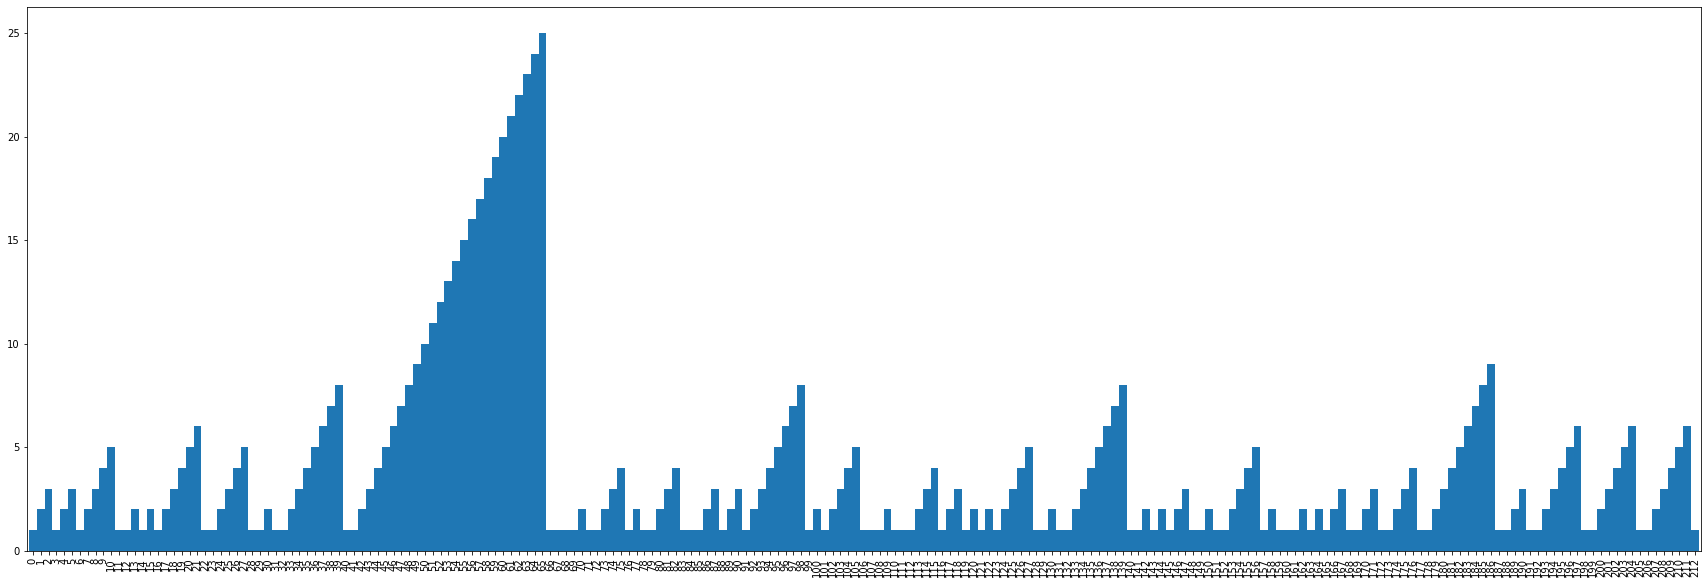

<IPython.core.display.Javascript object>

In [28]:
def plot_shots(shots):
    """Calculate and plot streak data.

    Args:
       shots (DataFrame): A dataframe, containing the shot data.
    """
    streaks = generate_streak_info(shots)

    fig, ax = plt.subplots(figsize=(30, 10))

    streaks["streak_counter"].plot.bar(ax=ax, width=1)


plot_shots(lebron_james_ft)

At the moment it is not very clear where the `miss` and `make` streaks are. So it would be a good idea to differentiate them.

## Differentiating Make and Miss Streaks

To separate `make` and `miss` streaks we can use different colors. And visually it will look better if they are directed in different directions. For this purpose we can multiply the length of `miss` streaks by `-1`.

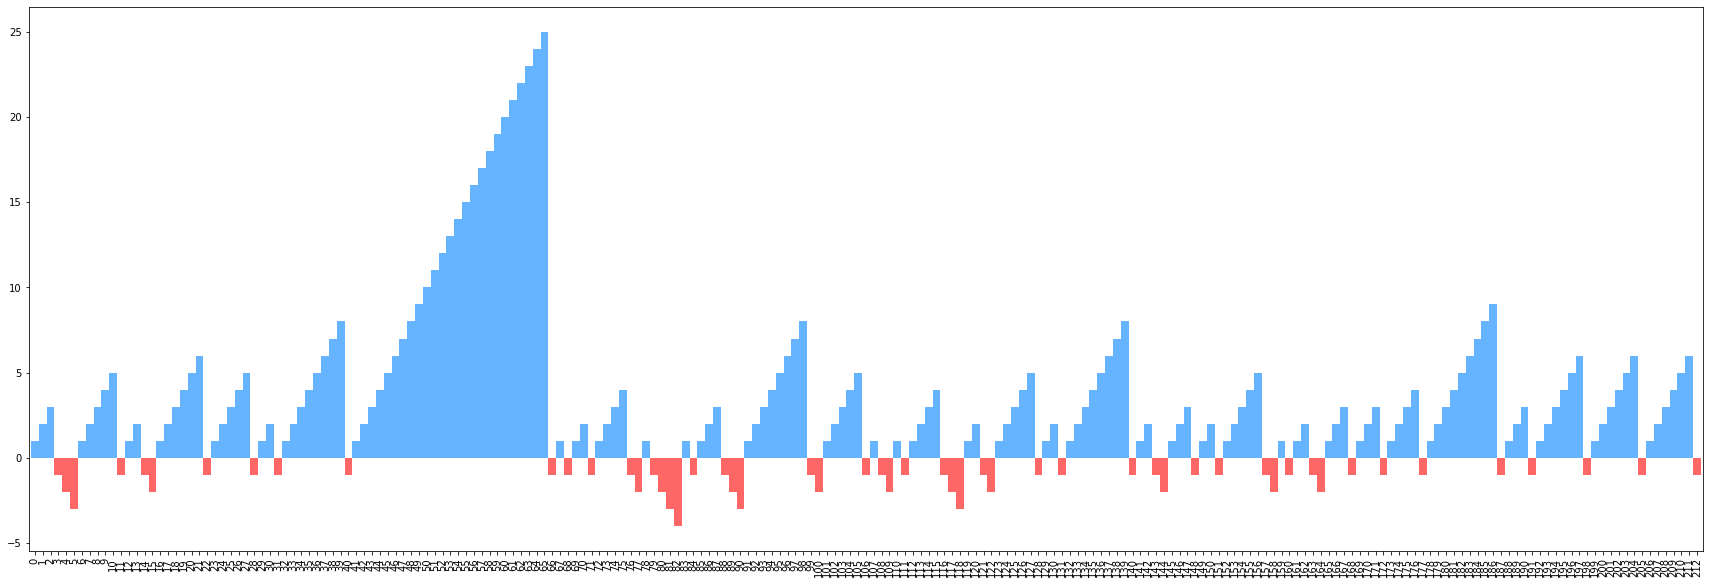

<IPython.core.display.Javascript object>

In [29]:
def plot_shots(shots):
    """Calculate and plot streak data.

    Args:
       shots (DataFrame): A dataframe, containing the shot data.
    """
    streaks = generate_streak_info(shots)
    streaks.loc[streaks["result"] == "miss", "streak_counter"] = (-1) * streaks[
        "streak_counter"
    ]

    fig, ax = plt.subplots(figsize=(30, 10))
    streaks["streak_counter"].plot.bar(
        ax=ax,
        width=1,
        color=streaks["result"].map({"make": "#66b3ff", "miss": "#ff6666"}),
    )


plot_shots(lebron_james_ft)

## Styling Plots

For nice-looking plots it would be better to remove insignificant information like ticks and spines. Moreover, we'll add a horizontal line to separate `miss` and `make` streaks.

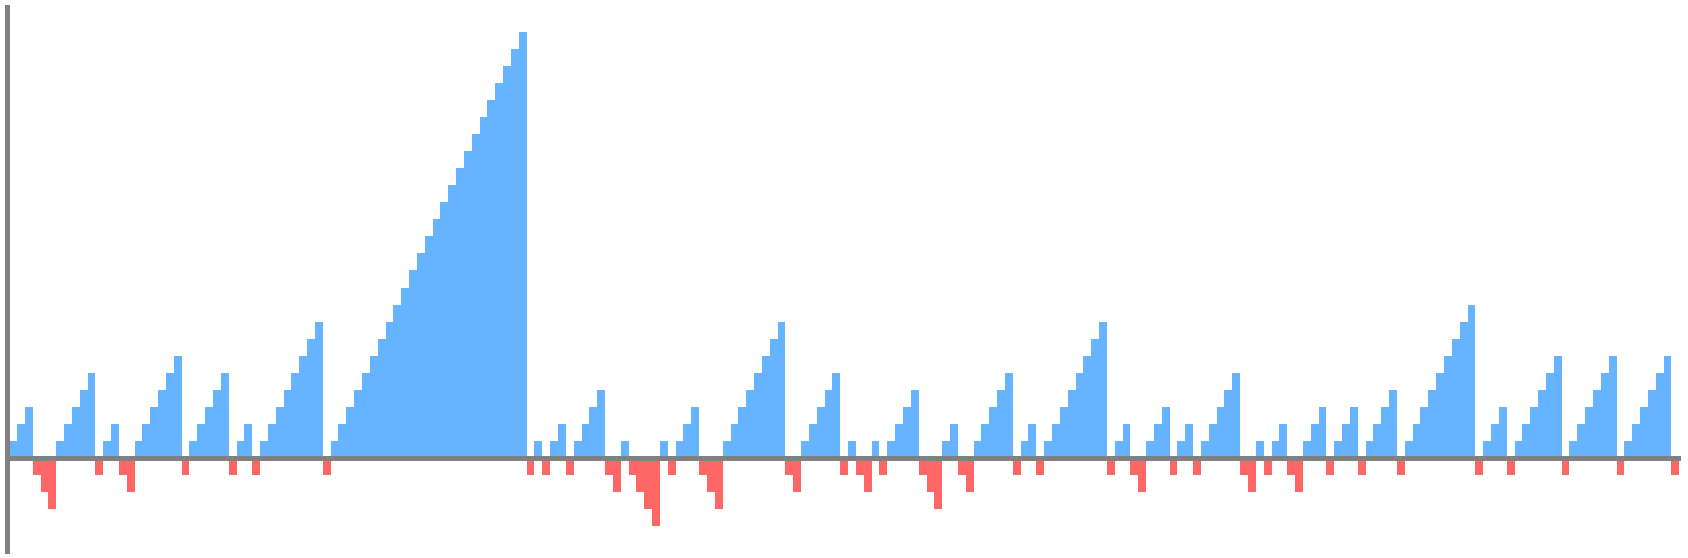

<IPython.core.display.Javascript object>

In [30]:
def plot_shots(shots):
    """Calculate and plot streak data.

    Args:
       shots (DataFrame): A dataframe, containing shot data.
    """
    streaks = generate_streak_info(shots)
    streaks.loc[streaks["result"] == "miss", "streak_counter"] = (-1) * streaks[
        "streak_counter"
    ]

    fig, ax = plt.subplots(figsize=(30, 10))
    streaks["streak_counter"].plot.bar(
        ax=ax,
        width=1,
        color=streaks["result"].map({"make": "#66b3ff", "miss": "#ff6666"}),
    )

    # add horizontal line
    plt.axhline(y=0, color="grey", linewidth=5)

    # remove ticks from all sides
    plt.tick_params(
        axis="both", bottom=False, labelbottom=False, left=False, labelleft=False
    )

    # remove spine from top, bottom and right
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # set the left spine to a line width of 5 and color grey
    ax.spines["left"].set_lw(5)
    ax.spines["left"].set_color("grey")


plot_shots(lebron_james_ft)

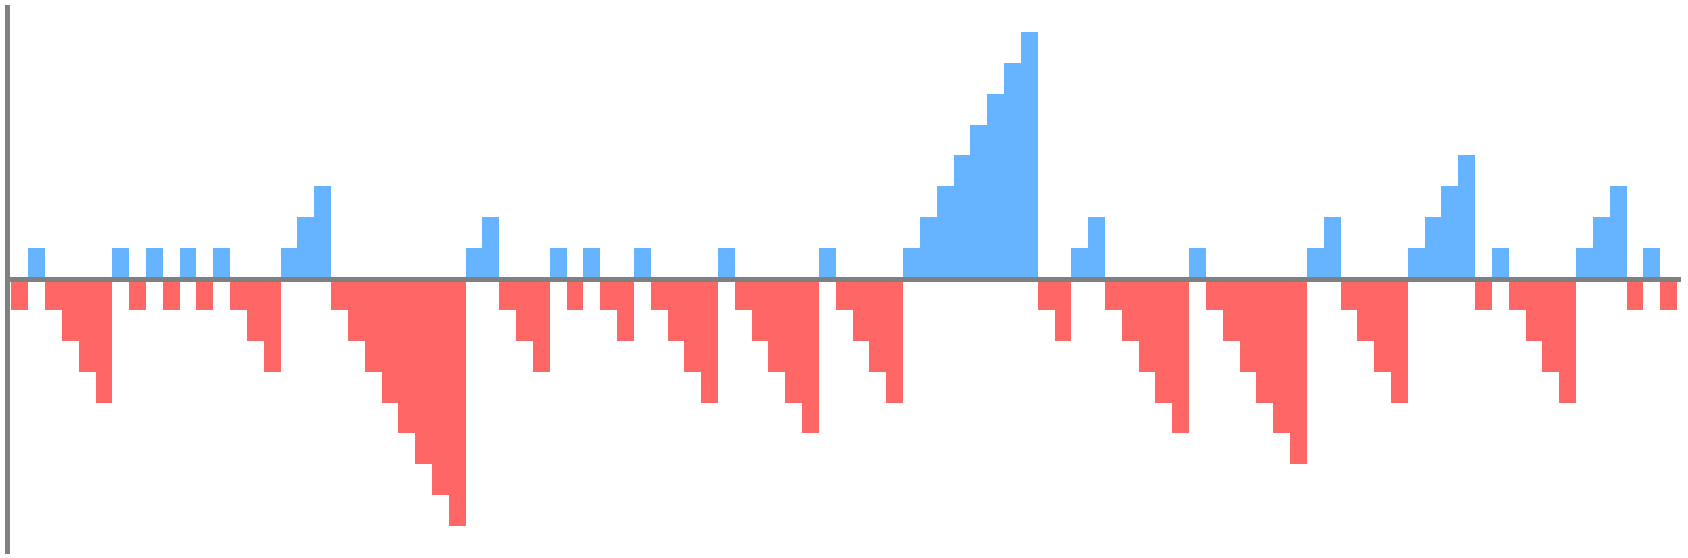

<IPython.core.display.Javascript object>

In [31]:
# test, that everything is ok
chris_paul_3pt = filter_shots("Chris Paul", "3PT")
plot_shots(chris_paul_3pt)

## Making Symmetrical Plots

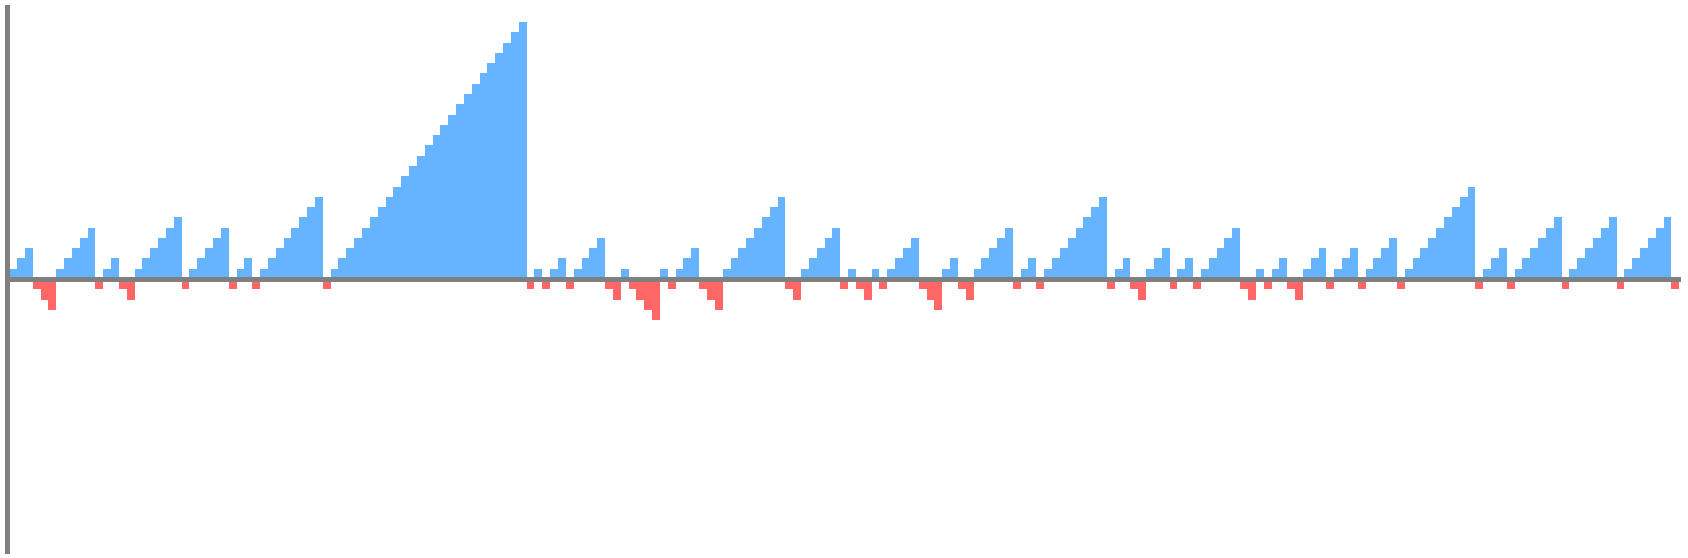

<IPython.core.display.Javascript object>

In [32]:
def plot_shots(shots):
    """Calculate and plot streak data.

    Args:
       shots (DataFrame): A dataframe, containing shot data.
    """
    streaks = generate_streak_info(shots)
    streaks.loc[streaks["result"] == "miss", "streak_counter"] = (-1) * streaks[
        "streak_counter"
    ]

    fig, ax = plt.subplots(figsize=(30, 10))
    streaks["streak_counter"].plot.bar(
        ax=ax,
        width=1,
        color=streaks["result"].map({"make": "#66b3ff", "miss": "#ff6666"}),
    )

    # add horizontal line
    plt.axhline(y=0, color="grey", linewidth=5)

    # remove ticks from all sides
    plt.tick_params(
        axis="both", bottom=False, labelbottom=False, left=False, labelleft=False
    )

    # remove spine from top, bottom and right
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # set the left spine to a line width of 5 and color grey
    ax.spines["left"].set_lw(5)
    ax.spines["left"].set_color("grey")

    # calculate the largest of the y limits, and use that to
    # set symmetrical limits
    limit = np.abs(plt.ylim()).max()
    plt.ylim(-1 * limit, limit)


plot_shots(lebron_james_ft)

## Adding background and titles

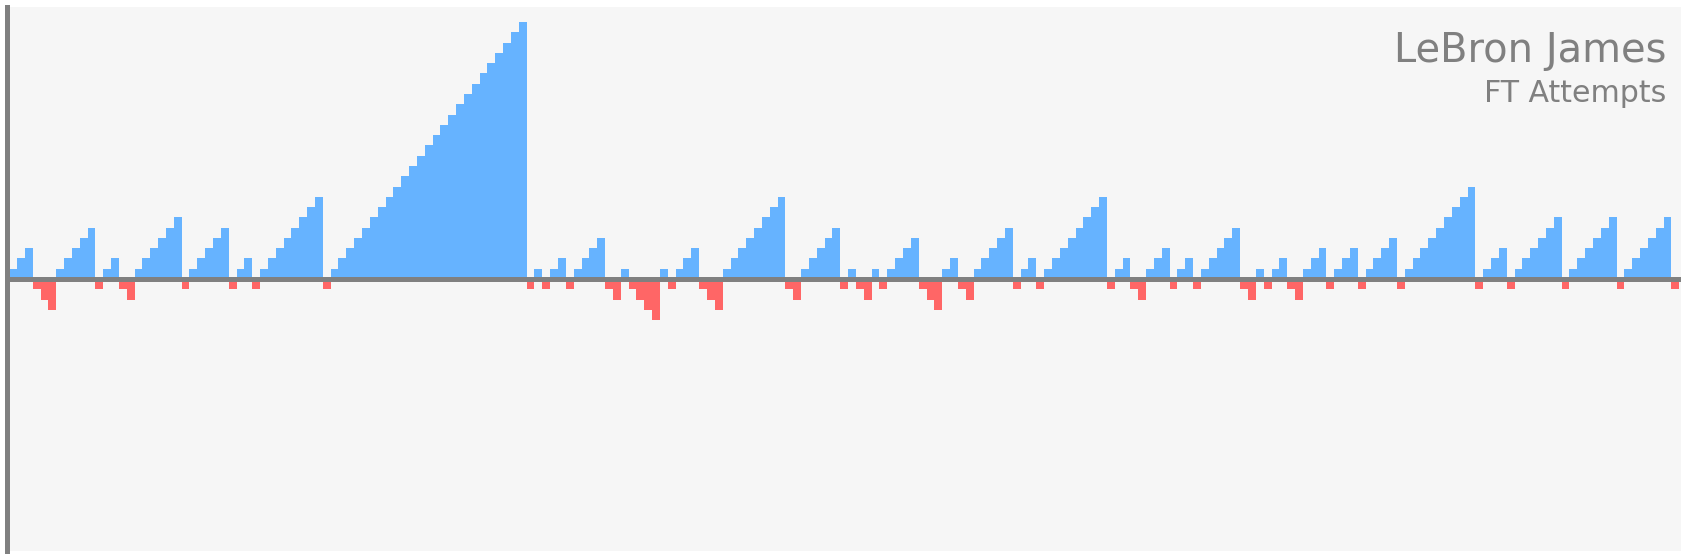

<IPython.core.display.Javascript object>

In [33]:
def plot_shots(shots):
    """Calculate and plot streak data.

    Args:
       shots (DataFrame): A dataframe, containing shot data.
    """
    streaks = generate_streak_info(shots)
    streaks.loc[streaks["result"] == "miss", "streak_counter"] = (-1) * streaks[
        "streak_counter"
    ]

    fig, ax = plt.subplots(figsize=(30, 10))
    streaks["streak_counter"].plot.bar(
        ax=ax,
        width=1,
        color=streaks["result"].map({"make": "#66b3ff", "miss": "#ff6666"}),
    )

    # add horizontal line
    plt.axhline(y=0, color="grey", linewidth=5)

    # remove ticks from all sides
    plt.tick_params(
        axis="both", bottom=False, labelbottom=False, left=False, labelleft=False
    )

    # remove spine from top, bottom and right
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # set the left spine to a line width of 5 and color grey
    ax.spines["left"].set_lw(5)
    ax.spines["left"].set_color("grey")

    # calculate the largest of the y limits, and use that to
    # set symmetrical limits
    limit = np.abs(plt.ylim()).max()
    plt.ylim(-1 * limit, limit)

    player_name = streaks["player_name"].iloc[0]
    shot_type = streaks["shot_type"].iloc[0] + " Attempts"

    # add summary text
    x = streaks.shape[0] * 0.99
    y1 = limit * 0.8
    y2 = limit * 0.65
    ax.text(x, y1, player_name, horizontalalignment="right", fontsize=40, color="grey")
    ax.text(x, y2, shot_type, horizontalalignment="right", fontsize=30, color="grey")

    # add background shading
    rect_coords = (-0.5, -1 * limit)
    rect_width = streaks.shape[0] + 0.5
    rect_height = 2 * limit
    bg = plt.Rectangle(rect_coords, rect_width, rect_height, color="#f6f6f6", zorder=-1)
    ax.add_patch(bg)


plot_shots(lebron_james_ft)

## Visualizing Interesting Streaks

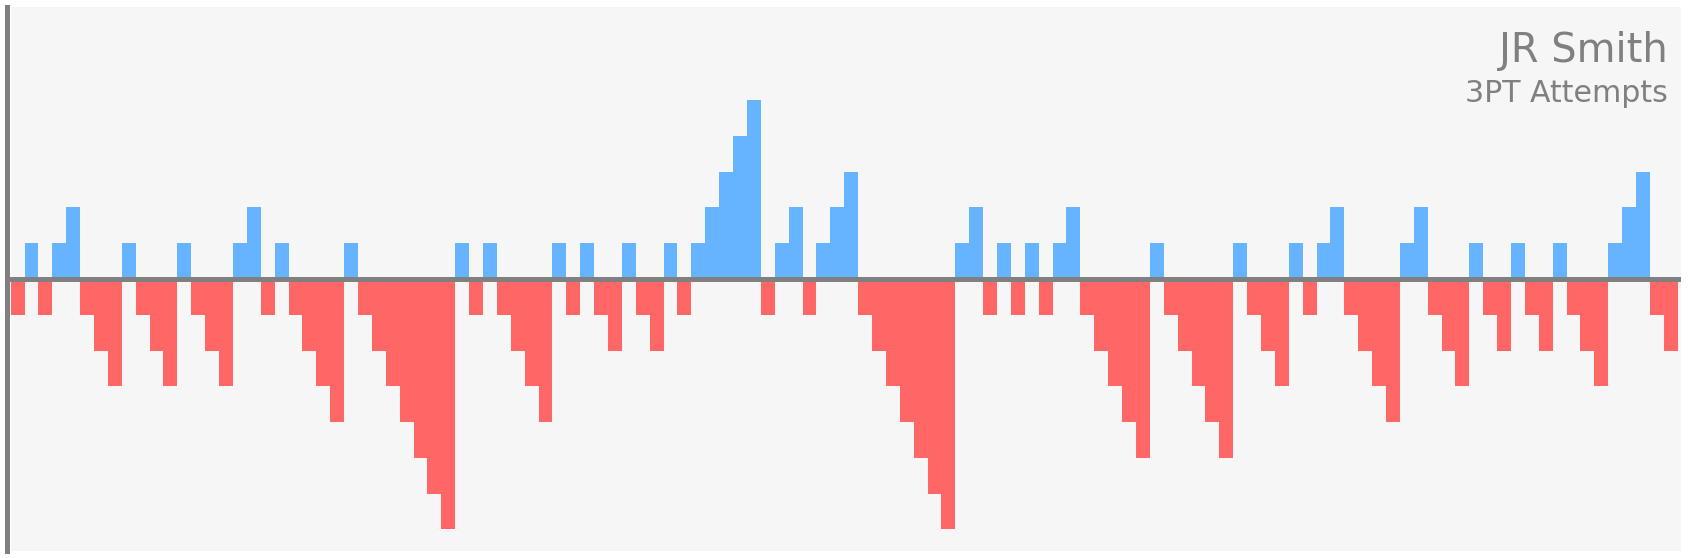

<IPython.core.display.Javascript object>

In [34]:
def filter_and_plot(player_name, shot_type):
    """Filter by player and shot type and then plot
    the resultant data.

    Args:
       player_name (str): A name of the player.
       shot_type (str): A shot type (`2PT`, `3PT`, `FT`).

    """
    player_shots = filter_shots(player_name, shot_type)

    plot_shots(player_shots)


filter_and_plot("JR Smith", "3PT")

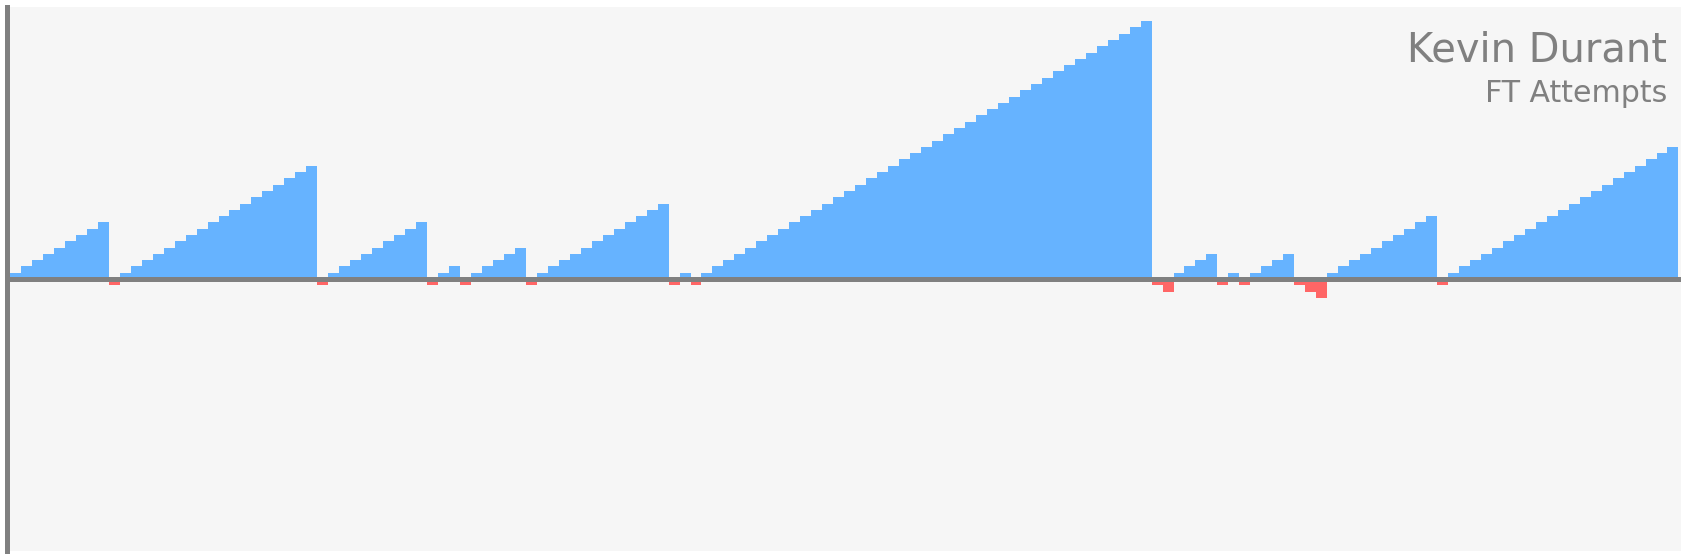

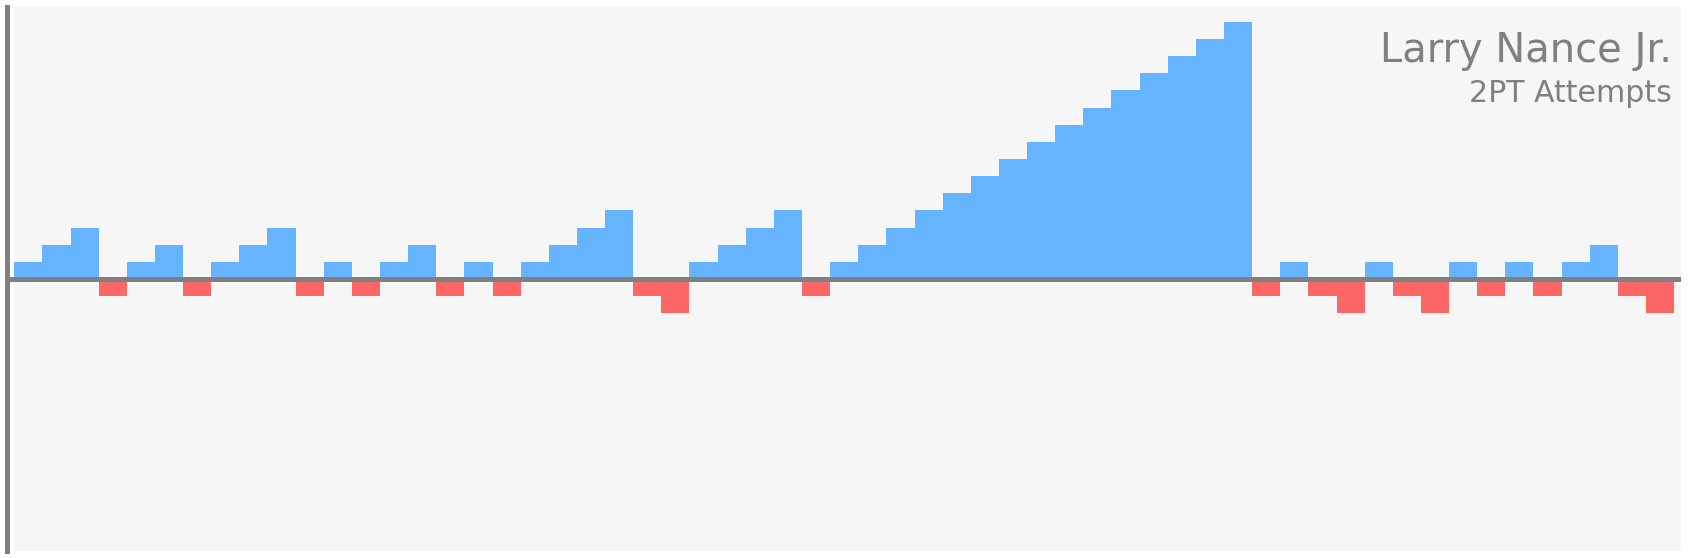

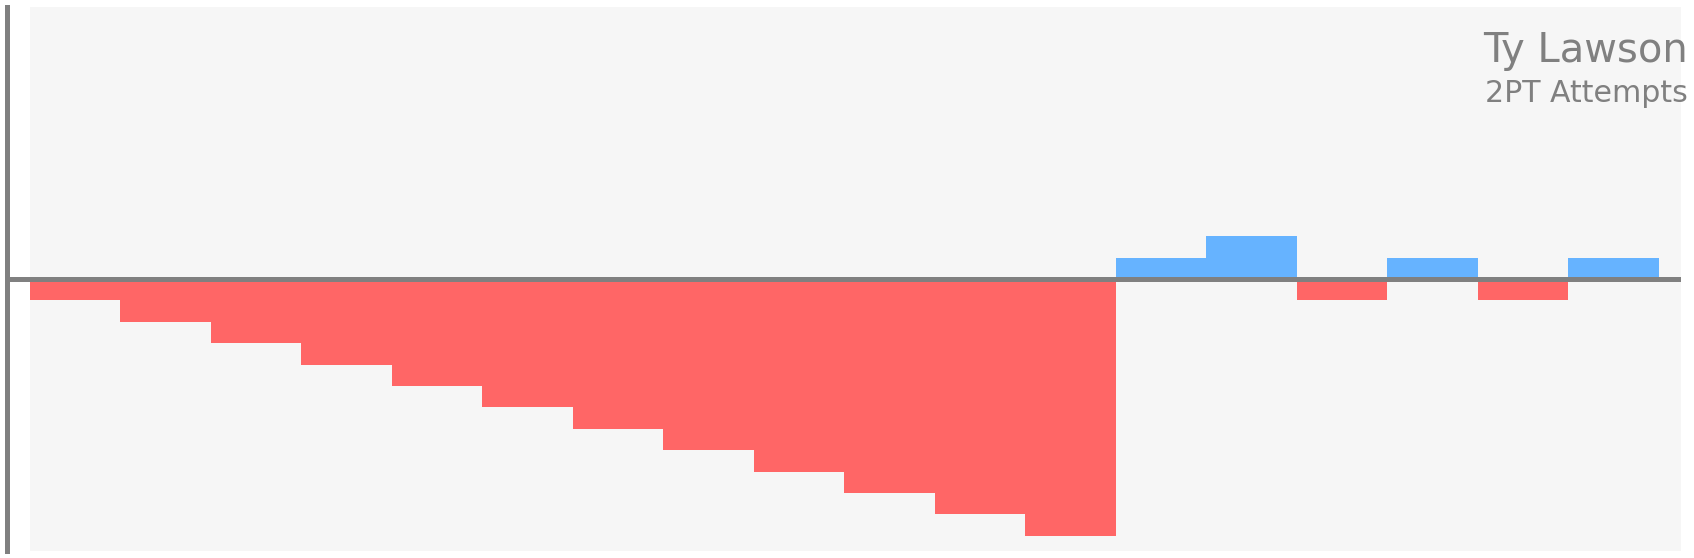

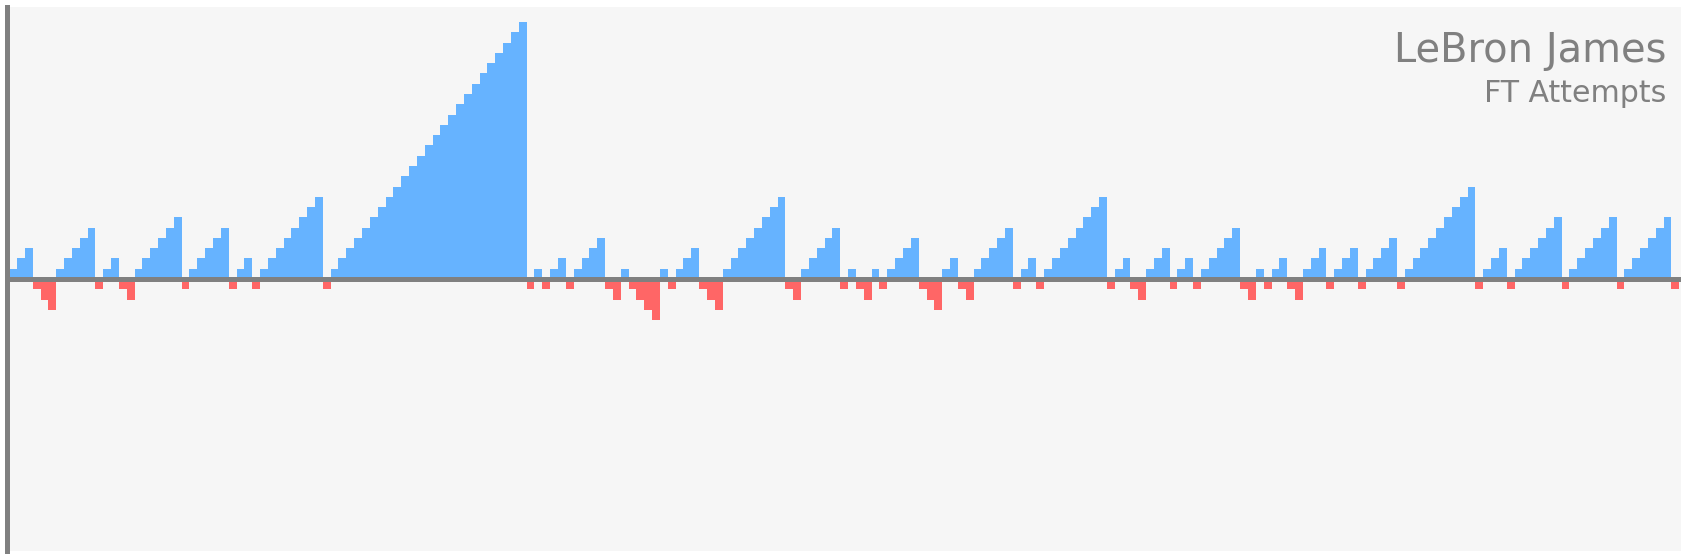

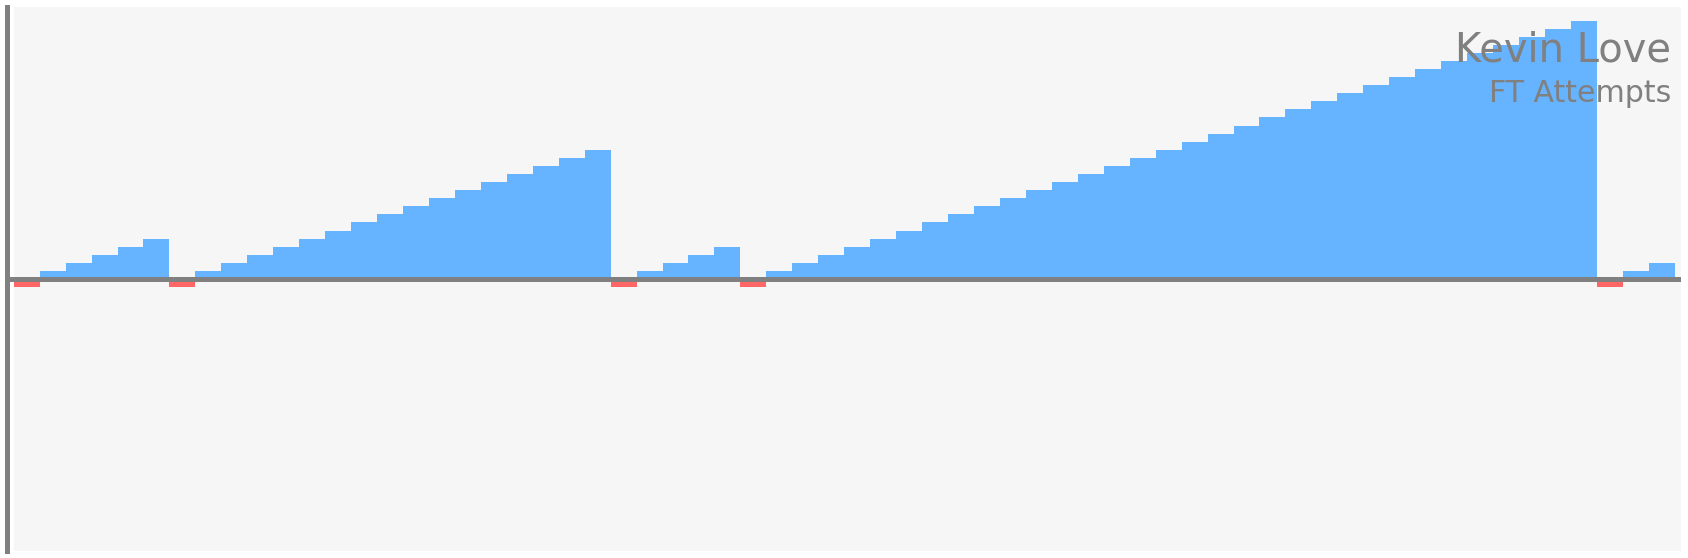

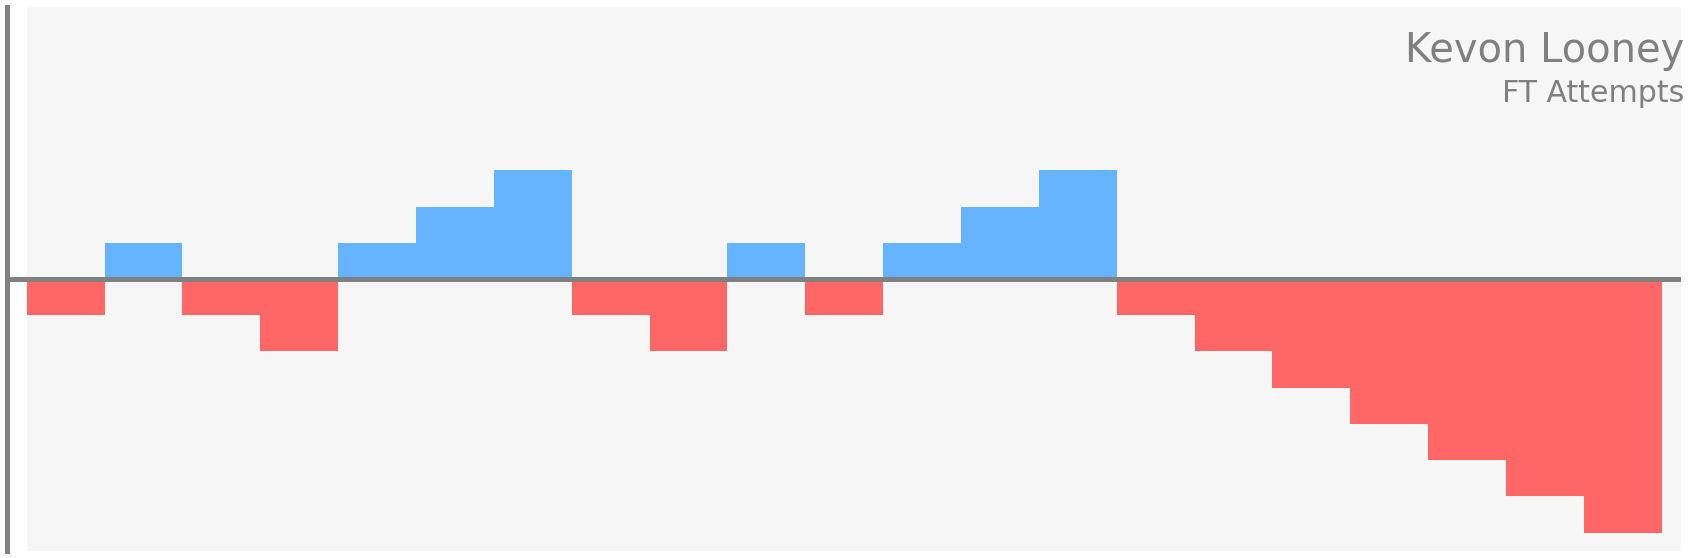

<IPython.core.display.Javascript object>

In [35]:
filter_and_plot("Kevin Durant", "FT")
filter_and_plot("Larry Nance Jr.", "2PT")
filter_and_plot("Ty Lawson", "2PT")
filter_and_plot("LeBron James", "FT")
filter_and_plot("Kevin Love", "FT")
filter_and_plot("Kevon Looney", "FT")

# Conclusion

Pandas and Matplotlib are great tools for analyzing and visualization any type of data, not only game data. These packages give you the opportunity to calculate metrics and values of interest, summarize data, discover trends, and present them in an attractive way.